In [73]:
from commpy.channels import awgn
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
import seaborn as sns
from pyMRI.utils import RMSE

## Conceito

In [74]:
metabolites = pymri.METABOLITES
met_i = 1

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
ws, t2s, M_0s = ws[met_i : met_i+1], t2s[met_i : met_i+1], M_0s[met_i : met_i+1]
spins_phi = np.zeros_like(M_0s)

print("Freqs (rad/s),\t\t T_2s (s),\t M_0s (U.A.),\t phis (rad)")
print(ws, "\t", t2s, "\t", M_0s, "\t", spins_phi)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

Freqs (rad/s),		 T_2s (s),	 M_0s (U.A.),	 phis (rad)
[2411.71251655] 	 [0.0735] 	 [0.4289] 	 [0.]
All frequencies are captured by the sampling rate.


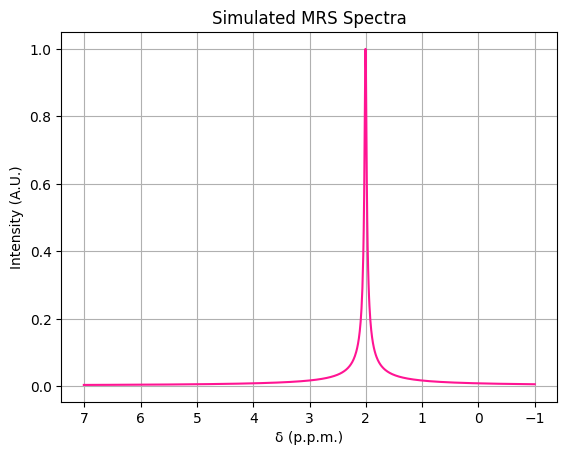

In [75]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop)
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )
sig_fft = sig_fft/np.max(sig_fft)
sig = np.fft.ifft(np.fft.ifftshift(sig_fft))

pymri.plot_chem_shifts(freqs, sig_fft)

In [76]:
L = 0.4
noise_threshold = 30
L_ = int(L*sig.size)

In [77]:
_, z_, r_ = pymri.filter_sig(sig, L, noise_threshold, return_poles_and_res=True)
original_s0s, original_phis, original_omegas, original_t2s = pymri.calculate_variables_from_z_and_r(z_, r_, dt)
original_t2s = 1/original_t2s

In [78]:
print(original_s0s)

[0.00664024]


In [79]:
SNR = 1.0
loc = 0.0
scale = 0.05

In [80]:
noise = np.random.normal(loc, scale, 2048) + 1j*np.random.normal(loc, scale, 2048)
c_sig_fft = sig_fft + noise
print(pymri.snr(c_sig_fft))

13.697710804293138


([], [])

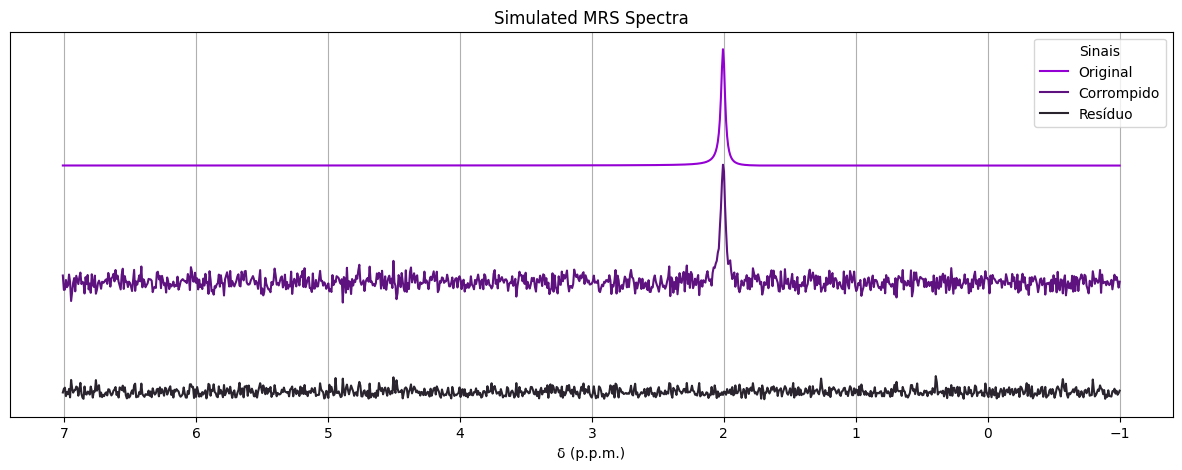

In [81]:
# c_sig_fft = awgn(sig_fft, SNR)
c_sig = np.fft.ifft(np.fft.ifftshift(c_sig_fft))

y_offset = 1.0
palette = sns.dark_palette("#9400D3", n_colors= 3, reverse = True)

plt.figure(figsize = (15, 5))
pymri.sns_plot_chem_shifts(freqs = np.array([freqs, freqs, freqs]), 
                           sig_fft = np.array([sig_fft + 2*y_offset, c_sig_fft + y_offset, c_sig_fft - sig_fft]), 
                           hue = np.array( [["Original"]*sig_fft.size, ["Corrompido"]*sig_fft.size, ["Resíduo"]*sig_fft.size]),
                           hue_label = "Sinais",
                           palette=palette)
plt.ylabel("")
plt.yticks([])


In [120]:
_, z, r = pymri.filter_sig(c_sig, L, 1.0, rcond=1e-15, return_poles_and_res=True)
s0s_, phis_, omegas_, t2s_ = pymri.calculate_variables_from_z_and_r(z, r, dt)
t2s_ = 1/t2s_

In [83]:
def filter_omegas(omegas : np.ndarray, dt : float):
    """Filters a given set of calculated omegas based on the Nyquist Frequency.
    
    Parameters
    ----------
    omegas : np.ndarray [rad/s]
        Array of omegas.
    dt : float [s]
        Time step of the simulation.
        
    Returns
    -------
    filtered_omegas : np.ndarray
        Boolean array that identifies the true frequencies of the omega array."""
    limit_omega = pymri.max_frequency(dt)
    return pymri.rad_to_hz(omegas) <= limit_omega

def filter_t2(t2s : np.ndarray, upper_bound : float = 0.5, lower_bound : float = -4.0):
    """Filters a given set of calculated T2s based on its physicial meaning.
    
    Parameters
    ----------
    t2s : np.ndarray
        T2s array.
    upper_bound : float = `0.5`
        Maximum order a T2 can have.
    lower_bound : float `-4.0`
        Minimum order a T2 can have.
    
    Returns 
    -------
    t2_filter_array : np.ndarray
        Boolean array that identifies the actual possible T2s."""
    lower_order_arr = np.log10(np.abs(t2s)) >= lower_bound
    higher_order_arr = np.log10(np.abs(t2s)) < upper_bound
    negative_arr = t2s >= 0.0
    t2_filter_arr = np.bitwise_and( np.bitwise_and( lower_order_arr, higher_order_arr), negative_arr)
    return t2_filter_arr


def compose_filters(filters : tuple):
    """Composes a set of given filters into one final filter.
    
    Parameters
    ----------
    filters : tuple
        The set of filters to be composed.
        
    Returns
    -------
    final_filter : np.ndarray
        The composition of all the filters."""
    
    n = len(filters)

    final_filter = np.full(filters[0].shape, True, dtype = bool)

    for i in range(n):
        final_filter = np.bitwise_and(final_filter, filters[i])

    return final_filter

In [121]:
omega_filter = filter_omegas(omegas_, dt)
t2_filter = filter_t2(t2s_)

filter = compose_filters((omega_filter, t2_filter))

print("Freqs filtradas \t Total")
print(omegas_[omega_filter].size, "\t\t\t", omegas_.size)
print("T2s filtrados \t Total")
print(omegas_[t2_filter].size, "\t\t\t", omegas_.size)
print("Total filtrados \t Total")
print(omegas_[filter].size, "\t\t\t", omegas_.size)

Freqs filtradas 	 Total
237 			 472
T2s filtrados 	 Total
415 			 472
Total filtrados 	 Total
208 			 472


In [122]:
a = 50.0
narrow_filter = np.bitwise_and( omegas_[filter] <= 2411.71251655 + a, omegas_[filter] > 2411.71251655 - a)
print(s0s_[filter][narrow_filter],  original_s0s)
print(phis_[filter][narrow_filter], original_phis)
print(omegas_[filter][narrow_filter], original_omegas)
print(t2s_[filter][narrow_filter], original_t2s)

# filtered_s0 =  s0s_[filter][narrow_filter]
# filtered_phi = phis_[filter][narrow_filter]
# filtered_omega = omegas_[filter][narrow_filter]
# filtered_t2 = t2s_[filter][narrow_filter]

filtered_s0 =  s0s_[filter]
filtered_phi = phis_[filter]
filtered_omega = omegas_[filter]
filtered_t2 = t2s_[filter]

[0.00054445 0.00031564 0.00022591 0.0056018  0.00016947 0.00047707] [0.00664024]
[1.46723755 1.75215288 4.81676313 0.14918951 3.25368226 4.81950161] [0.07535534]
[2364.37712215 2387.12623956 2429.76753776 2411.36936409 2447.78214595
 2459.99048814] [2411.71251655]
[0.16257373 0.24785422 0.4358721  0.0784302  0.74570219 0.12347038] [0.0735]


In [123]:
min_error = np.argmin(np.abs(filtered_omega - original_omegas))

In [124]:
filtered_pop = pymri.population(filtered_omega, filtered_t2, filtered_s0, filtered_phi)

filtered_sig, t = pymri.population_transverse_decay( t0, tn, dt, filtered_pop)
freqs, filtered_sig_fft = pymri.fourier_spectrum( filtered_sig, dt, B0 )

([], [])

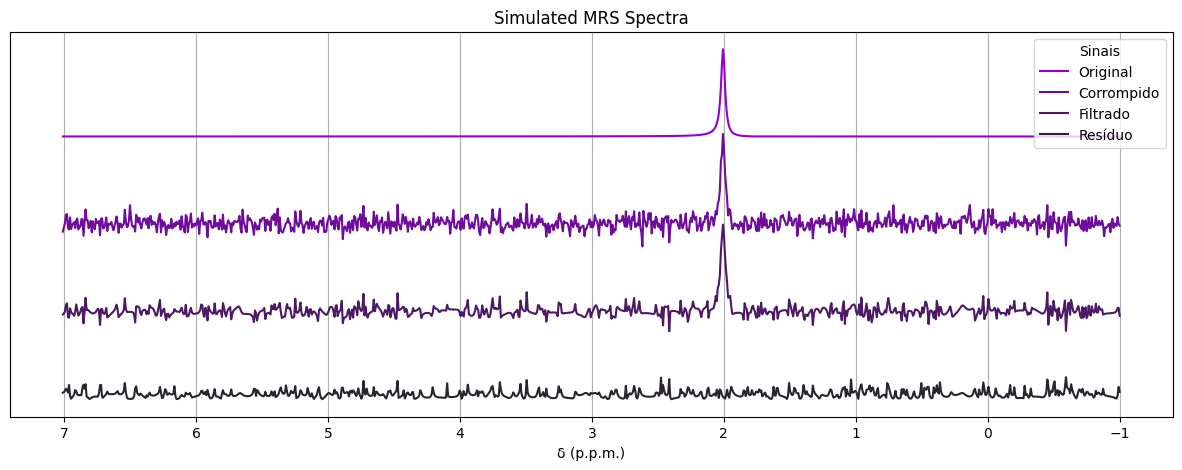

In [125]:
y_offset = 1.0
palette = sns.dark_palette("#9400D3", n_colors= 4, reverse = True)

plt.figure(figsize = (15, 5))
pymri.sns_plot_chem_shifts(freqs = np.array([freqs, freqs, freqs, freqs]), 
                           sig_fft = np.array([sig_fft + 3*y_offset, c_sig_fft + 2*y_offset, filtered_sig_fft + 1*y_offset, filtered_sig_fft - sig_fft]), 
                           hue = np.array( [["Original"]*sig_fft.size, ["Corrompido"]*sig_fft.size, ["Filtrado"]*sig_fft.size, ["Resíduo"]*sig_fft.size]),
                           hue_label = "Sinais",
                           palette=palette)
plt.ylabel("")
plt.yticks([])


Quanto pior a qualidade do sinal, maior deve ser a janela de frequência para conseguir reconstruir algo perto do tamanho do pico original. Isso vai pelo mesmo caminho que outros resultados anteriormente apresentados, como em [spec_components.ipynb](spec_components.ipynb), apontando que o ruído parece de fato corromper o sinal de uma maneira que não exista mais apenas um pico mas sim vários picos que compõe um pico final. *Avaliar isso.*

Uma possível métrica para avaliar a capacidade de identificação de um pico ruidoso seria sua proximidade de seu valor máximo de pico do valor normalizado, nesse caso, `1.0`. Quanto mais próximo desse valor, mais acurado é o pico identificado. Também é possível usar apenas o erro com relação ao sinal limpo. 

## Estatística

**Ideia de experimento para atualizar os dados do número de picos:**
Para cada valor de SNR, ir variando o tamanho da janela de filtro de frequências, centrada ao redor da frequência original do NAA. Para cada ampliação dos limites da janela, calcular o RMSE entre o sinal original e o sinal filtrado. A ideia é tentar usar o RMSE para demonstrar que quanto maior a janela, mais picos selecionados, maior a quantidade de picos necessários para recompor o pico original. Pelos resultados anteriormente demonstrados em [spec_components.ipynb](spec_components.ipynb), espera-se que quanto menor o SNR, mais picos são necessários para recompor o original.

In [89]:
scales = np.array([0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.001, 0.00075, 0.0005, 0.00025, 0.0001])
windows = np.arange(5.0, 105.0, 5.0)
loc = 0.0

print(scales.size, windows.size)
n_avgs = 50

12 20


In [90]:
shape = (n_avgs, scales.size, L_)
s0s__, phis__, omegas__, t2s__ = np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(shape)
snrs = np.zeros((n_avgs, scales.size))

In [93]:
rerun = False
ends_t2 = ["", "_2"]
filename_end = "_2"
folder_name = "files/"
subfolder_name = "one-peak/"

In [94]:
if rerun == True:
    for i in range(n_avgs):
        for j in range(scales.size):
                noise = np.random.normal(loc, scales[j], 2048) + 1j*np.random.normal(loc, scales[j], 2048)
                c_sig_fft = sig_fft + noise
                snrs[i, j] = pymri.snr(c_sig_fft)

                c_sig = np.fft.ifft(np.fft.ifftshift(c_sig_fft))

                _, z, r = pymri.filter_sig(c_sig, L, noise_threshold, rcond=1e-15, return_poles_and_res=True)
                s0s__[i, j, :], phis__[i, j, :], omegas__[i, j, :], t2s__[i, j, :] = pymri.calculate_variables_from_z_and_r(z, r, dt)
                t2s__[i, j, :] = 1/t2s__[i, j, :]
                        

In [ ]:
if rerun == True:
    np.save(folder_name + subfolder_name + "s0s__" + filename_end, s0s__)
    np.save(folder_name + subfolder_name + "phis__" + filename_end, phis__)
    np.save(folder_name + subfolder_name + "omegas__" + filename_end, omegas__)
    np.save(folder_name + subfolder_name + "t2s__" + filename_end, t2s__)
    np.save(folder_name + subfolder_name + "snrs" + filename_end, snrs)
    np.save(folder_name + subfolder_name + "scales" + filename_end, scales)

In [95]:
if rerun == False:
    s0s__ = np.load(folder_name + subfolder_name + "s0s__" + filename_end + ".npy")
    phis__ = np.load(folder_name + subfolder_name + "phis__" + filename_end + ".npy")
    omegas__ = np.load(folder_name + subfolder_name + "omegas__" + filename_end + ".npy")
    t2s__ = np.load(folder_name + subfolder_name + "t2s__" + filename_end + ".npy")
    snrs = np.load(folder_name + subfolder_name + "snrs" + filename_end + ".npy")
    scales = np.load(folder_name + subfolder_name + "scales" + filename_end + ".npy")

In [96]:
error = np.zeros((n_avgs, scales.size))
n_peaks = np.zeros((n_avgs, scales.size))
filtered_sigs_fft = np.zeros((n_avgs, scales.size, 2048), dtype = np.complex128)

for i in range(n_avgs):
    for j in range(scales.size):

        # Construção dos filtros
        omega_filter = filter_omegas(omegas__[i, j, :], dt)
        t2_filter = filter_t2(t2s__[i, j, :])

        filter = compose_filters((omega_filter, t2_filter))

        # Filtragem
        filtered_s0, filtered_phi, filtered_omega, filtered_t2, n_peaks[i, j] = pymri.select_peaks(s0s__[i, j, :][filter], 
                                                                                                        phis__[i, j, :][filter], 
                                                                                                        omegas__[i, j, :][filter], 
                                                                                                        t2s__[i, j, :][filter])

        min_error = np.argmin(np.abs(filtered_omega - original_omegas))


        # Geração do sinal filtrado
        filtered_pop = pymri.population(np.array([filtered_omega[min_error]]), 
                                        np.array([filtered_t2[min_error]]), 
                                        np.array([filtered_s0[min_error]]), 
                                        np.array([filtered_phi[min_error]]))

        filtered_sig, t = pymri.population_transverse_decay( t0, tn, dt, filtered_pop)
        freqs, filtered_sigs_fft[i, j, :] = pymri.fourier_spectrum( filtered_sig, dt, B0 )

        error[i, j] = RMSE(np.abs(sig_fft), np.abs(filtered_sigs_fft[i, j, :]))          
    

In [97]:
i_avg = 8
i_scale = 1
# i_window = 9

([], [])

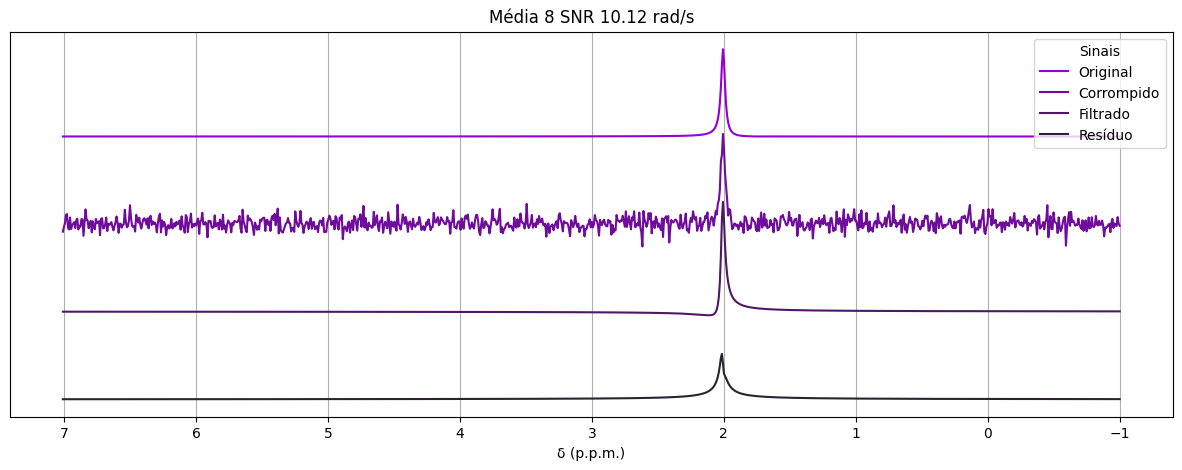

In [98]:
y_offset = 1.0
palette = sns.dark_palette("#9400D3", n_colors= 4, reverse = True)

filtered_sig_fft = filtered_sigs_fft[i_avg, i_scale, :]
c_sig, t = pymri.population_transverse_decay(t0, tn, dt, pymri.population(omegas__[i_avg, i_scale, :], t2s__[i_avg, i_scale, :], s0s__[i_avg, i_scale, :], phis__[i_avg, i_scale, :]))
freqs, c_sig_fft = pymri.fourier_spectrum(c_sig, dt, B0)

plt.figure(figsize = (15, 5))
pymri.sns_plot_chem_shifts(freqs = np.array([freqs, freqs, freqs, freqs]), 
                           sig_fft = np.array([sig_fft + 3*y_offset, c_sig_fft + 2*y_offset, filtered_sig_fft + 1*y_offset, filtered_sig_fft - sig_fft]), 
                           hue = np.array( [["Original"]*sig_fft.size, ["Corrompido"]*sig_fft.size, ["Filtrado"]*sig_fft.size, ["Resíduo"]*sig_fft.size]),
                           hue_label = "Sinais",
                           palette=palette)
plt.title(f"Média {i_avg} SNR {np.round(snrs[i_avg, i_scale], 2)} rad/s")
plt.ylabel("")
plt.yticks([])

In [99]:
avg_error = np.average(error, axis = 0)
std_error = np.std(error, axis = 0)
max_error = np.max(error, axis = 0)
min_error = np.min(error, axis = 0)

avg_n_peaks = np.average(n_peaks, axis = 0)
std_n_peaks = np.std(n_peaks, axis = 0)
max_n_peaks = np.max(n_peaks, axis = 0)
min_n_peaks = np.min(n_peaks, axis = 0)

avg_snr = np.average(snrs, axis = 0)
std_snr = np.std(n_peaks, axis = 0)
max_snr = np.max(snrs, axis = 0)
min_snr = np.min(snrs, axis = 0)


print(avg_n_peaks, avg_snr)

[31.66 26.42 27.86 23.28 15.48 12.12  8.48  2.32  2.    1.34  1.02  1.  ] [   7.36210823    9.67501542   14.3275308    28.12592355   71.47562595
   93.94585139  141.14558461  659.16856121  837.15006258 1116.97307908
 1500.21789353 1709.22940867]


In [100]:
print(min_error)

[2.34234263e-03 1.64365248e-03 6.90788217e-04 4.65100933e-04
 3.05351762e-04 1.43697021e-04 1.21822939e-04 9.81051465e-06
 7.64168220e-06 8.91263253e-06 8.63206804e-06 2.26930831e-06]


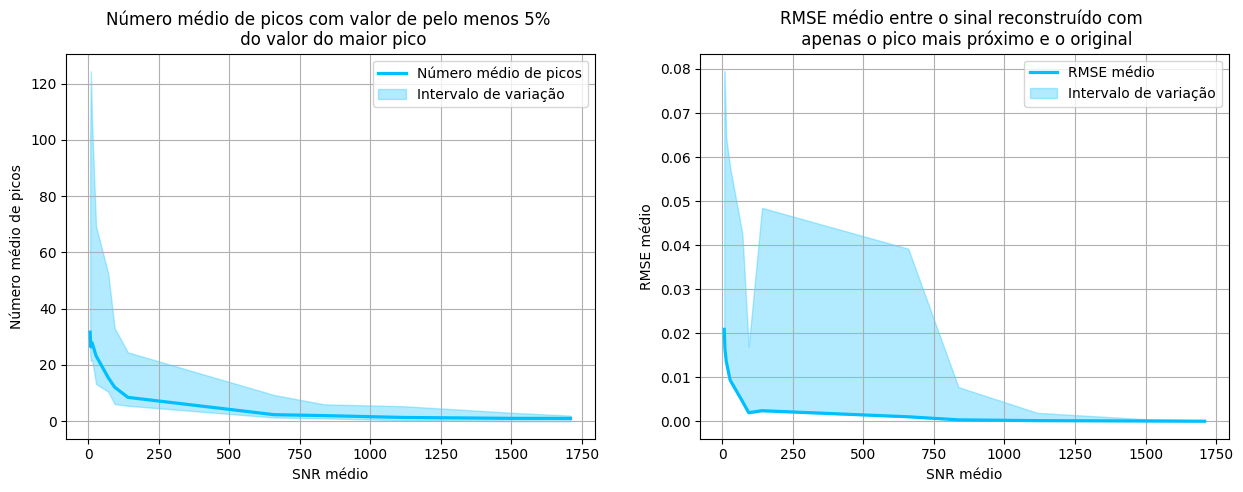

In [103]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(avg_snr, avg_n_peaks, c = "deepskyblue", label = "Número médio de picos", linewidth = 2.3)
plt.fill_between(avg_snr, avg_n_peaks - min_n_peaks, avg_n_peaks + max_n_peaks, color = "deepskyblue", alpha = 0.3, label = "Intervalo de variação")
plt.legend()
plt.xlabel("SNR médio")
plt.ylabel("Número médio de picos")
plt.title("Número médio de picos com valor de pelo menos 5% \n do valor do maior pico")
plt.grid()

plt.subplot(122)
plt.plot(avg_snr, avg_error, c = "deepskyblue", label = "RMSE médio", linewidth = 2.3)
plt.fill_between(avg_snr, avg_error - min_error, avg_error + max_error, color = "deepskyblue", alpha = 0.3, label = "Intervalo de variação")
plt.title("RMSE médio entre o sinal reconstruído com \n apenas o pico mais próximo e o original")
plt.legend()
plt.xlabel("SNR médio")
plt.ylabel("RMSE médio")
plt.grid()

Obteve-se os mesmos resultados apresentados em [spec_components.ipynb](spec_components.ipynb) com relação ao número de picos identificados entre os 5% maiores no sinal. A diferença aqui é que o RMSE calculado foi com relação ao sinal limpo, e a partir de um único pico identificado a partir do quão próximo era seu valor de frequência do valor de frequência de referência no sinal limpo. 

Um ponto que chamou a atenção foi a possibilidade de correção de fase. A fase é um parâmetro ajustável antes da aquisição de um sinal? É possível, a partir de uma correção artificial de fase (mudar manualmente a fase para a suposta fase a qual o sinal foi adquirido) diminuir a distorção do sinal?

In [126]:
np.log10(6.6*1e-3)

-2.1804560644581312